# Klastrowanie publicznych baz związków - Analiza danych

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw


W naszym projekcie korzystamy z danych dostepnym w bazie ChEMBL.
> ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs.

Skupimy się na kilku receptorach, mianowicie:
* Receptory serotoninowe: 5-HT1E, 5-HT1F
* Receptory acetylocholiny (muskarynowe): M1, M2
* Adrenoceptory: $\alpha$1A, $\alpha$ 1B
* Receptory dopaminowe: D1, D2
* Receptory histaminowe: H1, H2

#### Dane dotyczące tych receptorów w formacie CSV znajdują się w tym repozytorium, są też wstępnie wyczyszczone.
Dla zainteresowanych prezentujemy mini poradnik, który pokazuje jak ściągnąć takie dane:

1. Na [stronie bazy chEMBL](https://www.ebi.ac.uk/chembl/) należy wpisać w polu wyszukiwania w prawym górnym rogu nazwę receptora. Następnie należy przejść do zakładki "Targets"
2. By pracować na ludzkich receptorach, należy wybrać z liście z lewej strony Homo sapiens
3. Następnie wchodzimy na interesujący nas receptor
4. Przewijając w dół w polu Activity Charts widzimy wykres kołowy, na którym wybieramy Ki. Ten parametr mówi nam o powinowactwie związku do białka.
5. Tak przefiltowane dane można pobrać w postaci pliku CSV.




### Zobaczmy przykładowe dane (receptor dopaminowy D1)

In [8]:
df = pd.read_csv('data/cleaned_data/D1.csv') ### lub dowolna sciezka do pliku csv innego receptora
df.head(10)

,Molecule ChEMBL ID,Standard Value,Smiles
0,CHEMBL4098236,430.00,COc1ccccc1N1CCN(CCCCOc2ccn3ncc(C=O)c3c2)CC1
1,CHEMBL4105030,440.00,COc1ccccc1N1CCN(CCCCOc2ccn3nc(/C=N/O)cc3c2)CC1
2,CHEMBL4063282,1700.00,COc1ccccc1N1CCN(CCCC(=O)Nc2ccn3nccc3c2)CC1
3,CHEMBL3289648,524.81,Cc1ccc(N2CCN(CCCCc3ccc(F)cc3)CC2)nc1
4,CHEMBL54,270.00,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1
5,CHEMBL196370,10000.00,COc1ccc(NC(=O)N2CCN(c3ccccc3OC)CC2)cc1N1CCN(C)CC1
6,CHEMBL3913343,3.70,COc1cc2c(cc1O)[C@@H]1Cc3c(OC)ccc(OC)c3CN1CC2
7,CHEMBL307790,7.00,CN1CCc2cc(Cl)c(O)cc2[C@H]2c3ccccc3C[C@@H]21
8,CHEMBL3982119,50.07,COc1cc2c(cc1OC)[C@@H]1Cc3c(OC)ccc(OC)c3CN1CC2
9,CHEMBL25856,33.00,Oc1cc2c(cc1O)[C@H]1c3ccccc3CN[C@@H]1CC2


Jak widzimy, mamy do czynienia z 3 kolumnami:
* Molecule ChEMBL ID - identyfikator z basy ChEMBL
* Standard Value - wartość na podstawie której dokonywać będziemy klastrowania. Mówi nam o aktywności związku (im mniejsza wartość, tym związek bardziej aktywny)
* Smiles - strukturalna reprezentacja związku chemicznego w formacie tekstowym.

### Zobaczmy szczegółowe dane dotyczące tego zbioru

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803 entries, 0 to 1802
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  1803 non-null   object 
 1   Standard Value      1803 non-null   float64
 2   Smiles              1803 non-null   object 
dtypes: float64(1), object(2)
memory usage: 42.4+ KB


### Spójrzmy teraz na bardziej szczegółowe statystyki dotyczące Standard Value

In [9]:
df.describe()

,Standard Value
count,1803.000000
mean,4223.742552
std,19251.379071
min,0.100000
25%,36.310000
50%,380.000000
75%,2345.115000
max,524810.000000


Widzimy, że wartości są bardzo rozbieżne, różnica między wartością najmniejszą i największą jest bardzo duża. Średnia wynosi około 4 tysiące, natomiast uwagę zwracą duże odchylenie standardowe wynoszące ponad 19 tysięcy.

### Zobaczmy jak rozkładają się wartości Standard Value:
W tym celu przedstawmy je za pomocą histogramu

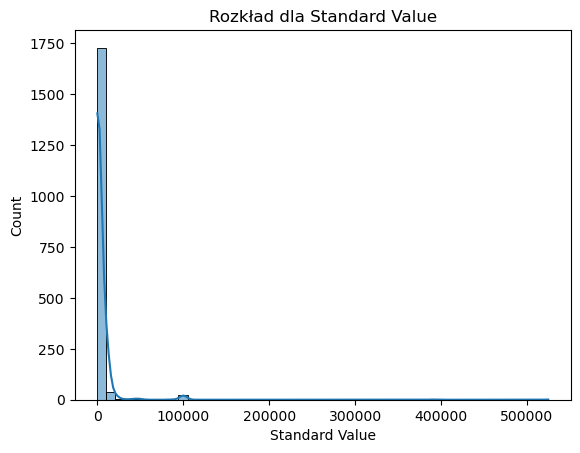

In [13]:
sns.histplot(df['Standard Value'], bins=50, kde=True)
plt.title('Rozkład dla Standard Value')
plt.show()

Widzimy że zdecydowana większość danych znajduje się w stosunkowo niskim przedziale, natomiast wartości ekstremalnie wysokie są sporadyczne.
### Wykres z powodu dużej rozpiętości wartości jest mało czytelny, przedstawimy go w skali logarytmicznej:

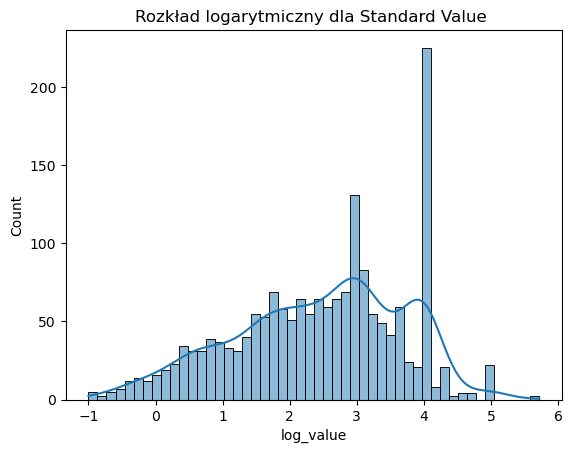

In [15]:
df['Log(Standard Value)'] = np.log10(df['Standard Value'])
sns.histplot(df['log_value'], bins=50, kde=True)
plt.title('Rozkład logarytmiczny dla Standard Value ')
plt.show()

Generalnie jako próg aktywności przyjmuje się 100 nM lub 1000 nM.
Związki powyżej 1000 nM traktujemy jako nieaktywne, natomiast próg aktywności jest "płynny" w zależności od konkretnego celu badawczego.
### Na potrzeny tego projektu ustalmy za próg aktywności 100nM.
### Sprawdźmy ile związków jest aktywnych

In [47]:
def label_activity(val):
    if val < 100:
        return 'Active'
    else:
        return 'Inactive'

df['Activity Class'] = df['Standard Value'].apply(label_activity)

In [48]:
activity_counts = df['Activity Class'].value_counts()
activity_counts

Activity Class
Inactive    1161
Active       642
Name: count, dtype: int64

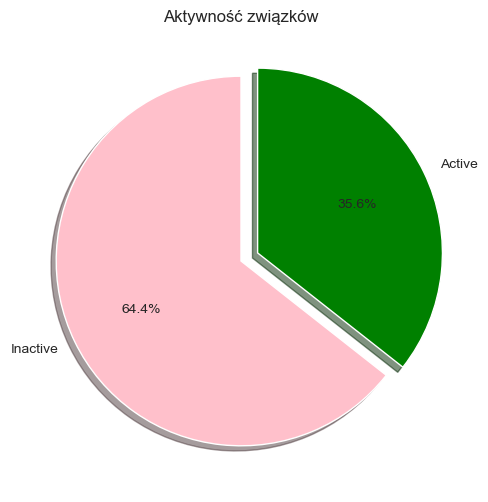

In [50]:
colors = ['pink', 'green']  # green, orange, red
explode = [0.1 if cls == 'Active' else 0 for cls in activity_counts.index]

activity_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    colors=colors,
    shadow=True,
    figsize=(6, 6)
)

plt.title('Aktywność związków')
plt.ylabel('')
plt.show()


Ustanawiając stosunkowo niski próg aktywności związków, otrzymujemy, że nieco ponad $\frac{1}{3}$ z nich jest aktywna


### Zwizualizujmy kilka związków ze zbioru danych

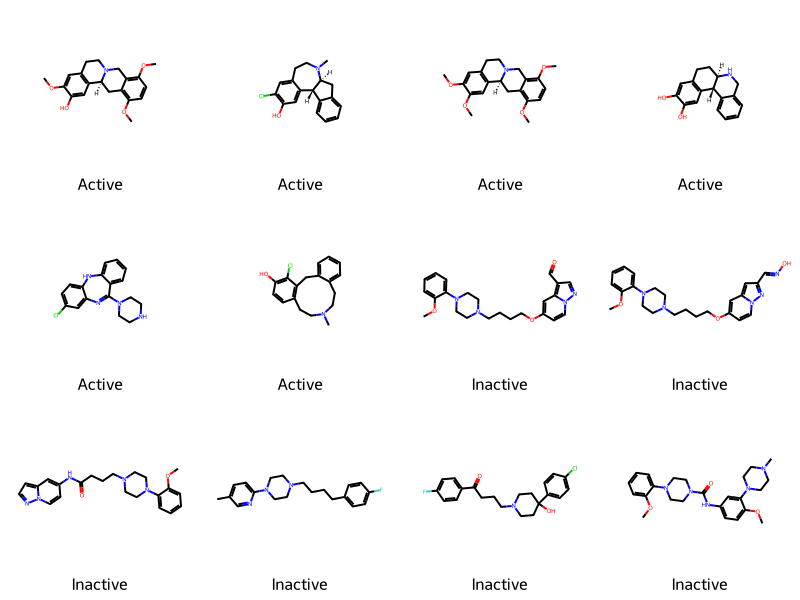

In [42]:
active_mols = df[df['Activity Class'] == 'Active'].head(6)['Smiles']
inactive_mols = df[df['Activity Class'] == 'Inactive'].head(6)['Smiles']

active_mols = [Chem.MolFromSmiles(smi) for smi in active_mols]
inactive_mols = [Chem.MolFromSmiles(smi) for smi in inactive_mols]

mols = active_mols + inactive_mols
legends = ['Active']*len(active_mols) + ['Inactive']*len(inactive_mols)

Draw.MolsToGridImage(mols, molsPerRow=4, legends=legends, subImgSize=(200, 200))